<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/Classification_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Exercise

The goal of this exercise is to implement different machine learning classification algorithms on a mock dataset. 

The feature selection techniques tested include:
* Correlation
* ANOVA F-tests
* PCA

The algorithms tested for single-label classification include
* Logistic regression - with regularization
* Naive Bayes 
* KNN
* Decision Tree
* Random Forest
* XGBoost
* SVM

The algorithms tested for multi-label classification include:
* Binary Relevance (LASSO Log Regression based)
* Classifier Chain (LASSO Log Regression based)
* Label Powerset (LASSO Log Regression based)
* ML-kNN
* Decision Tree
* SVM with OneVsRest



---



# Preprocessing

Dataset overview:
* 2 yi response variables
 * y1 is binary with 37% of ones
 * y2 has tree classes with a quite balanced proportion of each
* 339 features
 * 3 zi categorical variables
 * 336 xi numerical variables with varied values ranges
* 111 rows 
* no missing values

In this section, we split data into training (80%) and testing (20%). We then performed feature standardization. In the following sections, features selection and modeling were done on the training set; and performance evaluated on the testing set. Note that usually we do some visualization plots to see any obvious patterns in the data. Assuming that this is mock dataset and there is no hidden patterns, we will proceed directly to classification models.






In [ ]:
import pandas as pd
import numpy as np
import random
random.seed(0)

In [ ]:
# upload data
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['Data.csv']))
m, n = df.shape # SampleID is also here
n = n - 3
df

Saving Data.csv to Data (1).csv


,SampleID,y1,y2,z1,z2,z3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,...,x297,x298,x299,x300,x301,x302,x303,x304,x305,x306,x307,x308,x309,x310,x311,x312,x313,x314,x315,x316,x317,x318,x319,x320,x321,x322,x323,x324,x325,x326,x327,x328,x329,x330,x331,x332,x333,x334,x335,x336
0,1,0,2,1,0,1,0.018727,10.812500,0.756401,22.239814,0.322065,147.345663,78.146755,4.469050,5.965635,0.001913,2.713198,-0.452420,0.983692,0.020316,55.00250,-0.106614,24.871684,0.158884,147.51500,44.484237,3.962403,5.727206,0.001049,3.490549,-0.504573,0.988784,0.455486,0.257462,0.411071,0.233991,0.370202,0.212352,0.353408,0.190457,...,58.041222,0.130578,229.73000,131.602387,4.255559,5.840392,0.000644,3.622651,-0.661224,0.998234,1.441117,0.414487,1.299091,0.376787,1.168484,0.342067,1.127765,0.307083,0.528432,0.152772,0.173240,0.058648,1.243793,0.362185,0.679973,0.348910,1.000000,1.134647,107.404730,0.259827,0.322045,107.404730,1.962986,1.295453,1.757529,0.705076,0.000000e+00,1.257910,0.830042,1.757267
1,2,0,2,1,0,1,0.013118,25.979592,0.693347,42.471739,0.232407,128.955357,143.907366,4.790603,6.358148,0.001495,3.130454,-0.552370,0.996052,0.018988,89.84375,-0.033971,43.462836,0.098296,129.39125,84.007594,4.288358,5.817892,0.000900,3.728859,-0.658813,0.998204,0.037640,0.342979,0.031322,0.312781,0.025637,0.284930,0.045776,0.248285,...,149.873592,0.098640,190.73875,349.533119,4.578125,5.841642,0.000579,3.845497,-0.699760,0.998991,0.419882,0.720626,0.377556,0.653600,0.338680,0.591904,0.334672,0.542207,0.153604,0.264932,0.048448,0.097492,0.361063,0.627613,0.804977,1.047531,0.517578,0.238046,33.552931,0.351454,0.503824,33.552931,2.154299,0.724061,1.173643,-0.348824,9.744894e-01,2.503124,-0.284387,3.581636
2,3,0,2,1,0,1,0.014411,18.674745,0.639091,26.254285,0.270639,118.672194,86.342393,4.680475,6.262459,0.001843,2.996819,-0.478239,0.989739,0.019916,66.53625,-0.236689,27.062830,0.131179,118.73375,41.715069,3.913942,5.747206,0.001191,3.512493,-0.590937,0.995766,-0.238853,0.267585,-0.217700,0.244126,-0.198134,0.222487,-0.172192,0.192813,...,104.277344,0.087705,189.19750,212.919375,4.291986,5.829142,0.000485,4.031572,-0.681458,0.998754,0.415104,0.601647,0.370800,0.547535,0.330221,0.497699,0.345955,0.442737,0.151359,0.222073,0.042390,0.087330,0.353497,0.526579,0.556228,1.260504,0.658203,0.178006,25.743694,0.247866,0.406830,25.743694,1.866083,0.634228,1.065046,-0.373406,7.578785e-01,2.239489,-0.135308,4.152148
3,4,0,2,1,0,1,0.023381,9.346301,0.729793,17.153855,0.348273,164.609056,59.269118,4.297778,5.778610,0.001993,2.582917,-0.423454,0.976676,0.024362,45.15875,-0.316249,17.079223,0.128227,165.00875,23.158144,3.587157,5.548971,0.001260,3.246588,-0.492422,0.985692,0.911376,0.220230,0.821642,0.201861,0.739115,0.184860,0.712715,0.152948,...,51.182484,0.125964,215.86750,103.112437,4.290809,5.880392,0.000715,3.530606,-0.660485,0.998337,1.115815,0.388882,1.005149,0.354094,0.903411,0.322000,0.877550,0.283774,0.408945,0.143718,0.132653,0.056402,0.962047,0.340607,0.425628,-0.014371,1.000000,0.985288,66.659063,0.180535,0.270890,66.659063,1.768058,1.020563,1.407764,0.253800,0.000000e+00,1.514258,0.511240,2.727560
4,5,0,2,1,0,0,0.029926,5.448980,0.641496,7.914013,0.409615,125.413265,26.207072,3.987424,5.475259,0.003574,2.163605,-0.370326,0.955371,0.028084,17.54375,0.003692,8.930355,0.271841,125.33625,18.177669,3.626614,5.357108,0.002005,2.837268,-0.429575,0.970275,-0.090164,0.162219,-0.082164,0.146601,-0.074766,0.132268,-0.065001,0.125415,...,25.963619,0.133014,138.69750,49.739475,3.954538,5.669082,0.001301,3.327085,-0.551474,0.992488,-0.979706,0.293037,-0.884903,0.269678,-0.797640,0.248232,-0.755659,0.202579,-0.359774,0.109119,-0.121569,0.054241,-0.848020,0.260702,0.297791,0.676969,0.969238,-0.873852,50.374648,0.132736,0.203097,50.374648,0.054665,0.887189,-0.565955,-1.377671,1.161151e-01,1.432336,-1.141510,4.300340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# get labels
x = df.loc[:, 'z1':]
y = df[['y1', 'y2']]

Distribution of y1 values


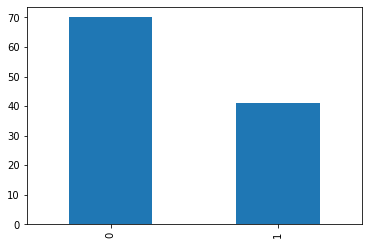

In [ ]:
import matplotlib.pyplot as plt
print("Distribution of y1 values")
pd.value_counts(y['y1']).plot.bar()

Distribution of y2 values


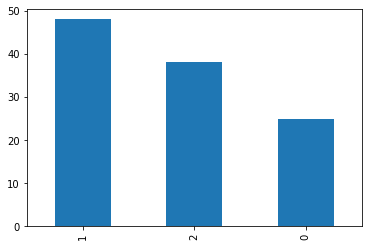

In [ ]:
print("Distribution of y2 values")
pd.value_counts(y['y2']).plot.bar()

In [ ]:
# check missing values
t = pd.DataFrame(df.isnull().sum())
t.columns = ['nmissing']
t.nmissing.value_counts()

0    342
Name: nmissing, dtype: int64

In [451]:
# split data into training and testing
from sklearn import model_selection
np.random.seed(0)

# stratify option will distributed data based on values of y, to avoid cases of all 0s going into testing data
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 0)

print('training data has ' + str(x_train.shape[0]) + ' observation with ' + str(x_train.shape[1]) + ' features')
print('test data has ' + str(x_test.shape[0]) + ' observation with ' + str(x_test.shape[1]) + ' features')

training data has 88 observation with 339 features
test data has 23 observation with 339 features


In [452]:
# since features have very different range of values, we do standardization 
# standardize based on training data, and apply to test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

# Feature Selection



## Low Variance Features

We first check if there is any features with zero variance. If so, they are not contributing to the classification and can be removed. Results show no feature with zero variance.


In [ ]:
from sklearn.feature_selection import VarianceThreshold
thresholder = VarianceThreshold(threshold=0)
print("Variables Kept: ", thresholder.fit_transform(x).shape[1])

Variables Kept:  339


## Correlation between features

Then we check if there are features that are highly correlated between themselves. Dropping highly correlated features can also prevent multicollinearity in regression models. Results show that only 1 pair of variables had correlation greater than 0.8. So this method would not help with feature selection.


In [ ]:
corr = abs(x.corr())
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
cols = [column for column in upper.columns if any(upper[column] < 0.8)]
print("Variables Kept: ", len(cols)) 

Variables Kept:  338


## Correlation with the response

We will check the correlation between each variable and the response, and keep the variables that are most correlated with the response. The drawback of this method is that it not take into consideration the interaction between the variables. From the plots we can see that none of the predictors have a strong linear correlation with the response (all correlations < 0.3)
* How were the thresholds chosen? Manually tuned the thresholds to obtain the best accuracy in the binary classification of y1.

Variables Kept:  52
Variables with highest correlation with y1
Variables Kept:  64
Variables with highest correlation with y2


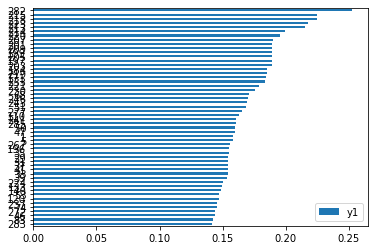

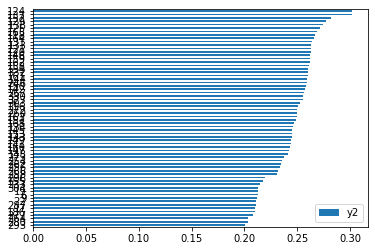

In [ ]:
threshold1 = 0.14
threshold2 = 0.2

# correlation matrix
df_train = pd.concat((x_train, y_train), axis=1)
corr = df_train.corr()
corr1 = abs(corr["y1"])[:-2]
corr2 = abs(corr["y2"])[:-2]

# check which features are most correlated with y1
cols1_corr = pd.DataFrame(corr1[corr1 > threshold1])
cols1_corr.sort_values(by='y1', ascending=True).plot(kind = "barh")
x_train_corr_y1 = x_train[cols1_corr.index.values] 
x_test_corr_y1 = x_test[cols1_corr.index.values]
print("Variables Kept: ", len(cols1_corr)) 
print("Variables with highest correlation with y1")

# check which features are most correlated with y2
cols2_corr = pd.DataFrame(corr2[corr2 > threshold2])
cols2_corr.sort_values(by='y2', ascending=True).plot(kind = "barh")
x_train_corr_y2 = x_train[cols2_corr.index.values] 
x_test_corr_y2 = x_test[cols2_corr.index.values] 
print("Variables Kept: ", len(cols2_corr)) 
print("Variables with highest correlation with y2")

## Statistical Tests 


We can also select the top k features that have the highest F-scores in ANOVA. 
* Why k = 55 for y1? Manually tunned k so that the logistic regression Approach II gives the highest AUC


Variables Kept:  55
Index(['x330', 'x323', 'x333', 'x313', 'x307', 'x315', 'x309', 'x319', 'x311',
       'x317', 'x324', 'x328', 'x325', 'x167', 'x145', 'x139', 'x147', 'x141',
       'x151', 'x143', 'x331', 'x149', 'x329', 'x162', 'x299', 'x286', 'x156',
       'x164', 'x160', 'x157', 'x163', 'x66', 'x79', 'x62', 'x75', 'x111',
       'x335', 'x61', 'x161', 'x77', 'x67', 'x65', 'x78', 'x89', 'x83', 'x91',
       'x85', 'x95', 'x87', 'x274', 'x243', 'x93', 'x230', 'x106', 'x80'],
      dtype='object')
Variables with highest F-scores (y1)


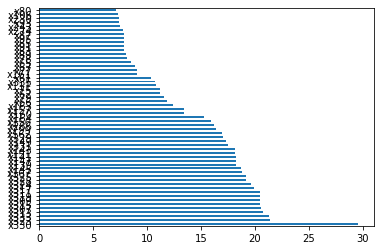

In [ ]:
import sklearn.feature_selection as fs
k = 55

# ANOVA and F-values (y1)
selector = fs.SelectKBest(k=k)   # default method f_classif
x_train_anova_y1 = selector.fit_transform(x_train, y_train['y1'])
x_test_anova_y1 = selector.transform(x_test)

# get F-test scores and p-values
temp = np.asarray(fs.f_classif(x_train, y_train['y1']))  
cols1_anova = pd.Series(temp[0], index = list(df.loc[:, 'z1':].columns)).sort_values(ascending=False).head(k)
cols1_anova.plot(kind = "barh")
print("Variables Kept: ", k) 
print(cols1_anova.index)
print("Variables with highest F-scores (y1)")

Variables Kept:  55
Index(['z2', 'x328', 'x325', 'x330', 'x329', 'x324', 'x224', 'x171', 'z1',
       'x331', 'x313', 'x307', 'x315', 'x309', 'x319', 'x311', 'x317', 'x299',
       'x286', 'x122', 'x210', 'x161', 'x123', 'x322', 'x156', 'x162', 'x314',
       'x145', 'x53', 'x163', 'x139', 'x147', 'x141', 'x151', 'x143', 'x334',
       'x308', 'x149', 'x316', 'x310', 'x320', 'x312', 'x135', 'x273', 'x110',
       'x71', 'x90', 'x280', 'x166', 'x63', 'x212', 'x154', 'x220', 'x60',
       'x73'],
      dtype='object')
Variables with highest F-scores (y2)


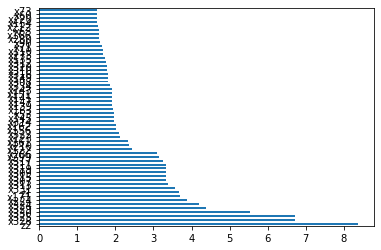

In [ ]:
# ANOVA and F-values (y2)
selector = fs.SelectKBest(k=k)   # default method f_classif
x_train_anova_y2 = selector.fit_transform(x_train, y_train['y2'])
x_test_anova_y2 = selector.transform(x_test)

# get F-test scores and p-values
temp = np.asarray(fs.f_classif(x_train, y_train['y2']))  
cols2_anova = pd.Series(temp[0], index = list(df.loc[:, 'z1':].columns)).sort_values(ascending=False).head(k)
cols2_anova.plot(kind = "barh")

print("Variables Kept: ", k) 
print(cols2_anova.index)
print("Variables with highest F-scores (y2)")

In [475]:
# Union of the significant features for y1 and y2
cols_anova = cols1_anova + cols2_anova
print("Variables Kept: ", len(cols_anova)) 
print(cols_anova.index)

idx = [x.columns.get_loc(c) for c in list(cols_anova.index)]
x_train_anova = x_train.iloc[:, idx ]
x_test_anova = x_test.iloc[:, idx ]

Variables Kept:  84
Index(['x106', 'x110', 'x111', 'x122', 'x123', 'x135', 'x139', 'x141', 'x143',
       'x145', 'x147', 'x149', 'x151', 'x154', 'x156', 'x157', 'x160', 'x161',
       'x162', 'x163', 'x164', 'x166', 'x167', 'x171', 'x210', 'x212', 'x220',
       'x224', 'x230', 'x243', 'x273', 'x274', 'x280', 'x286', 'x299', 'x307',
       'x308', 'x309', 'x310', 'x311', 'x312', 'x313', 'x314', 'x315', 'x316',
       'x317', 'x319', 'x320', 'x322', 'x323', 'x324', 'x325', 'x328', 'x329',
       'x330', 'x331', 'x333', 'x334', 'x335', 'x53', 'x60', 'x61', 'x62',
       'x63', 'x65', 'x66', 'x67', 'x71', 'x73', 'x75', 'x77', 'x78', 'x79',
       'x80', 'x83', 'x85', 'x87', 'x89', 'x90', 'x91', 'x93', 'x95', 'z1',
       'z2'],
      dtype='object')


## Dimension Reduction with PCA 

PCA can project data into lower dimensions while preserving maximum amount of information (variance). However, PCA does not consider the true label and may "throw out" important classification patterns, so it is often used in unsupervised learning but not supervised learning. We will test if PCA provides some value to our exercise.

For some reason, in the eigendecomposition step we are only able to get 6 eigenvectors. So PCA can reduce to 6 dimensions at most.


In [ ]:
# self-implemented function to perform PCA
import sklearn.preprocessing as skpp
import scipy.sparse.linalg as ll

def computePCA(data, K):         # data needs to be m data points x n features
    m, n = data.shape            # combining n features into k

    # normalize the data because features have very different ranges, dividing by std
    stdA = np.std(data, axis = 0)               
    stdA = skpp.normalize(stdA.reshape(1,-1))  
    Anew = data @ np.diag(np.ones(stdA.shape[1])/stdA[0])  
    Anew = Anew.T      

    # Eigendecomposition
    mu = np.mean(Anew, axis = 1)                      # n x 1
    xc = Anew - mu[:, None]
    C = np.dot(xc, xc.T)/m                            # covariance matrix, n x n
    l, w = ll.eigs(C)        
    idx = l.argsort()[::-1][:K]                       # k largest 
    l = l[idx].real
    w = w[:,idx].real

    # extract principal components 
    pc = np.empty([K, m])           
    for i in range(K):
        pc[i, :] = np.dot(w[:,i].T, xc)/np.sqrt(l[i])
    pc = pc.T
    
    return pc

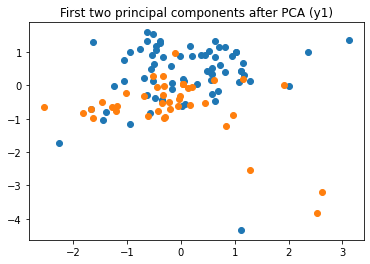

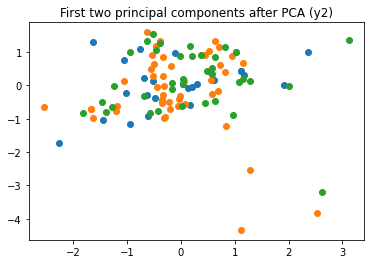

In [ ]:
# test projecting into 2 dimensions
x_pca = computePCA(np.asarray(x), 2)  # m x k 

import matplotlib.pyplot as plt

for i in range(max(y['y1'])+1):
  idx = np.where(y['y1'] == i)
  plt.scatter(x_pca[idx, 0], x_pca[idx, 1])
plt.title("First two principal components after PCA (y1)")
plt.show()

for i in range(max(y['y2'])+1):
  idx = np.where(y['y2'] == i)
  plt.scatter(x_pca[idx, 0], x_pca[idx, 1])
plt.title("First two principal components after PCA (y2)")
plt.show()

In [ ]:
# reducing into 6 dimensions
# NOTE: cannot go beyond 6, does this mean that the data is R6 i.e. only 6 linearly independent features?
x_pca = computePCA(np.asarray(x), 6)  # m x k 
x_pca.shape

(111, 6)

In [ ]:
# create test and train datasets using PCA reduced dimensions
x_train_pca, x_test_pca, y_train_pca, y_test_pca = model_selection.train_test_split(x_pca, y, test_size=0.2, stratify = y, random_state = 0)

print('training data has ' + str(x_train_pca.shape[0]) + ' observation with ' + str(x_train_pca.shape[1]) + ' features')
print('test data has ' + str(x_test_pca.shape[0]) + ' observation with ' + str(x_test_pca.shape[1]) + ' features')

training data has 88 observation with 6 features
test data has 23 observation with 6 features


# Binary Classification

We implemented the following  classification models for Y1:
* Model 1 Logistic regression - with regularization
* Model 2 Naive Bayes 
* Model 3 KNN
* Model 4 Decision Tree
* Model 5 Random Forest
* Model 6 XGBoost
* Model 7 SVM

Refer to Summary section for an overview.



## Logistic Regression


y1 is binary so we apply logistic regression directly. We will try the following approaches
* Approach 1: log regression with LASSO regularization
* Approach 2: log regression with ANOVA selected features
* Approach 3: log regression with PCA reduced dimensions - best AUC
* Approach 4: log regression with features most correlated with the response

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

LASSO can be used as feature selection procedure since l1 regularization sets the coefficient of not as important variables to zero. LASSO is also shown to work well with imbalanced data. We use a grid search to tune the find the optimal penalty parameter.

In [ ]:
# Approach 1 LASSO
param_grid = {
    'penalty': ['l1'], 
    'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 
         0.08, 0.081, 0.082, 0.083, 0.084, 0.09, 0.1]
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=200), param_grid, cv=5)
Grid_LR.fit(x_train, y_train['y1'])
print("Best parameters: " + str(Grid_LR.best_params_))
print("Best score: " + str(Grid_LR.best_score_))

model11_y1 = Grid_LR.best_estimator_
model11_y1.fit(x_train, y_train['y1'])
pred = model11_y1.predict_proba(x_test)[:,1]
print("AUC: ", roc_auc_score(y_test['y1'], pred))

Best parameters: {'C': 0.074, 'penalty': 'l1'}
Best score: 0.681045751633987
AUC:  0.8250000000000001


In [ ]:
# Approach 2 ANOVA
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C':[0.001, 0.003, 0.004, 0.005, 0.006, 0.01, 0.02, 0.03, 0.04, 
         0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=200), param_grid, cv=5)
Grid_LR.fit(x_train_anova_y1, y_train['y1'])
print("Best parameters: " + str(Grid_LR.best_params_))
print("Best score: " + str(Grid_LR.best_score_))

model12_y1 = Grid_LR.best_estimator_
model12_y1.fit(x_train_anova_y1, y_train['y1'])
pred = model12_y1.predict_proba(x_test_anova_y1)[:,1]
model1_y1_score = model12_y1.score(x_test_anova_y1, y_test['y1'])
print("AUC: ", roc_auc_score(y_test['y1'], pred))

Best parameters: {'C': 0.005, 'penalty': 'l2'}
Best score: 0.7601307189542483
AUC:  0.8500000000000001


In [ ]:
# Approach 3 PCA 
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.033, 0.035, 0.038, 0.04, 0.05, 0.06)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=5)
Grid_LR.fit(x_train_pca, y_train['y1'])
print("Best parameters: " + str(Grid_LR.best_params_))
print("Best score: " + str(Grid_LR.best_score_))

model13_y1 = Grid_LR.best_estimator_
model13_y1.fit(x_train_pca, y_train['y1'])
pred = model13_y1.predict_proba(x_test_pca)[:,1]
print("AUC: ", roc_auc_score(y_test['y1'], pred))

Best parameters: {'C': 0.033, 'penalty': 'l2'}
Best score: 0.7045751633986927
AUC:  0.8916666666666667


In [ ]:
# Approach 4 correlation
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 
         0.081, 0.082,  0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.09, 0.1]
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=200), param_grid, cv=5)
Grid_LR.fit(x_train_corr_y1, y_train['y1'])
print("Best parameters: " + str(Grid_LR.best_params_))
print("Best score: " + str(Grid_LR.best_score_))

model14_y1 = Grid_LR.best_estimator_
model14_y1.fit(x_train_corr_y1, y_train['y1'])
pred = model14_y1.predict_proba(x_test_corr_y1)[:,1]
print("AUC: ", roc_auc_score(y_test['y1'], pred))

Best parameters: {'C': 0.05, 'penalty': 'l2'}
Best score: 0.6803921568627451
AUC:  0.825


## Naive Bayes

Assumes the likelihood of the features follows Normal distribution. Also assumes that all features are independent between them. From previous correlation checks, only one pair had correlation above 0.5 so this assumption seems valid.

* Approach 1: Naive Bayes without feature selection
* Approach 2: Naive Bayes with ANOVA selected variables
 * Performed the best based on AUC
* Approach 3: Naive Bayes with PCA dimension reduction
 * Interestingly, performs very bad
* Approach 4: Naive Bayes with features most correlated with y1

In [ ]:
from sklearn.naive_bayes import GaussianNB
model2_y1 = GaussianNB()

pred = model2_y1.fit(x_train, y_train['y1']).predict(x_test)
print("Approach 1 AUC: ", roc_auc_score(y_test['y1'], pred))

pred = model2_y1.fit(x_train_anova_y1, y_train['y1']).predict(x_test_anova_y1)
print("Approach 2 AUC: ", roc_auc_score(y_test['y1'], pred))
model2_y1_score = model12_y1.score(x_test_anova_y1, y_test['y1'])

pred = model2_y1.fit(x_train_pca, y_train['y1']).predict(x_test_pca)
print("Approach 3 AUC: ", roc_auc_score(y_test['y1'], pred))

pred = model2_y1.fit(x_train_corr_y1, y_train['y1']).predict(x_test_corr_y1)
print("Approach 4 AUC: ", roc_auc_score(y_test['y1'], pred))

Approach 1 AUC:  0.7125
Approach 2 AUC:  0.8083333333333333
Approach 3 AUC:  0.7791666666666667
Approach 4 AUC:  0.7750000000000001


## KNN

KNN classifies based on majority vote of the clusters and does not study patterns in data. May be susceptible to outliers, so our standardization alleviates this issue. Note that KNN often does not work well with high dimentions. KNN prediction returns binary labels so AUC might not be a good metric. 

* Approach 1: KNN without feature selection
 * Actually performed the best on this test data
* Approach 2: KNN with ANOVA selected features
* Approach 3: KNN with PCA reduced dimensions
* Approach 4: KNN with features most correlated with the response
 * shows very different results depending on the correlation threshold used to select variables

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

model3_y1 = KNeighborsClassifier(n_neighbors=2)

# Approach 1
model3_y1.fit(x_train, y_train['y1'])
pred = model3_y1.predict(x_test)
print("Accuracy: ", model3_y1.score(x_test, y_test['y1']))
print("Approach 1 confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))
model3_y1_score = model3_y1.score(x_test, y_test['y1'])

# Approach 2
model3_y1.fit(x_train_anova_y1, y_train['y1'])
pred = model3_y1.predict(x_test_anova_y1)
print("Accuracy: ", model3_y1.score(x_test_anova_y2, y_test['y1']))
print("Approach 2 confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))

# Approach 3
model3_y1.fit(x_train_pca, y_train['y1'])
pred = model3_y1.predict(x_test_pca)
print("Accuracy: ", model3_y1.score(x_test_pca, y_test['y1']))
print("Approach 3 confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))

# Approach 4
model3_y1.fit(x_train_corr_y1, y_train['y1'])
pred = model3_y1.predict(x_test_corr_y1)
print("Accuracy: ", model3_y1.score(x_test_corr_y1, y_test['y1']))
print("Approach 4 confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))

Accuracy:  0.8695652173913043
Approach 1 confusion matrix: 
[[15  0]
 [ 3  5]]
Accuracy:  0.6521739130434783
Approach 2 confusion matrix: 
[[15  0]
 [ 5  3]]
Accuracy:  0.7391304347826086
Approach 3 confusion matrix: 
[[14  1]
 [ 5  3]]
Accuracy:  0.782608695652174
Approach 4 confusion matrix: 
[[14  1]
 [ 4  4]]


## Decision Tree

The decision tree has inherent feature selection. So we apply the tree to the data without feature selection. Interestingly, the features with highest feature importance based on the tree is different than those selected by statistical tests. 

Note that decision trees do not need features to be normalized; and we could have used additional parameters to prune the tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

model4_y1 = DecisionTreeClassifier(random_state=0)
model4_y1.fit(x_train, y_train['y1'])
pred = model4_y1.predict(x_test)
print("Accuracy: ", model4_y1.score(x_test, y_test['y1']))
print("Confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))
model4_y1_score = model4_y1.score(x_test, y_test['y1'])

Accuracy:  0.8695652173913043
Confusion matrix: 
[[12  3]
 [ 0  8]]


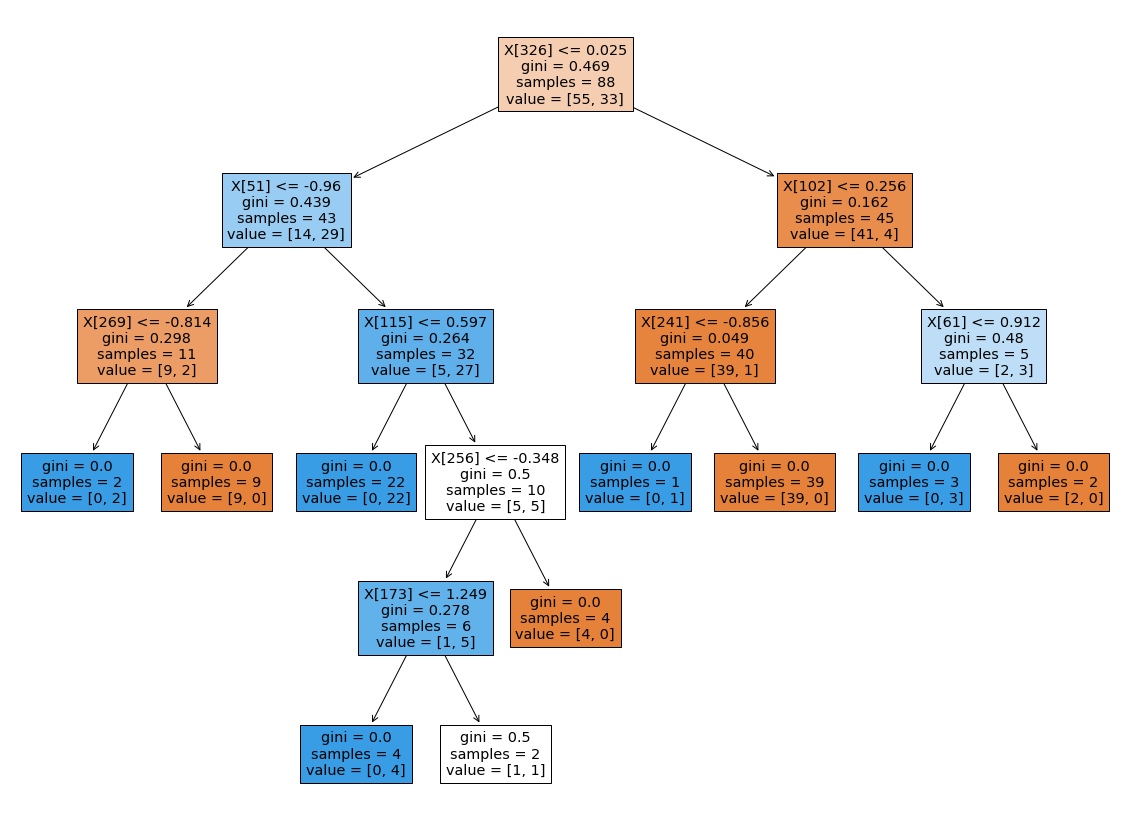

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,15))
plt = tree.plot_tree(model4_y1, filled=True)

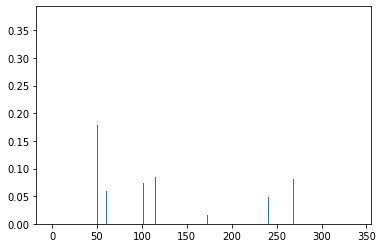

x324 0.3745935448665479
x49 0.17822344490696362
x113 0.08540372670807453
x254 0.08281573498964802
x267 0.08130999435347261
x100 0.07301587301587303
x59 0.05962732919254658
x239 0.048447204968944065
x171 0.016563146997929608
z3 0.0


In [ ]:
# see feature importance
from matplotlib import pyplot as plt

importance = model4_y1.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

for importance, name in sorted(zip(model4_y1.feature_importances_, x.columns), reverse=True)[:10]:
    print (name, importance)

## Random Forest

Let's also test the classification with multiple trees, random forest, which controls overfitting. However, results did not improve compared to the single decision trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators' : [3,5,7,9,11]
}

Grid_RF = GridSearchCV(RandomForestClassifier(random_state=0), parameters, cv=5)
Grid_RF.fit(x_train, y_train['y1'])
print("Best parameters: " + str(Grid_RF.best_params_))
print("Best score: " + str(Grid_RF.best_score_))

model5_y1 = Grid_RF.best_estimator_
model5_y1.fit(x_train, y_train['y1'])
pred = model5_y1.predict(x_test)
print("Accuracy: ", model5_y1.score(x_test, y_test['y1']))
print("Confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))
model5_y1_score = model5_y1.score(x_test, y_test['y1'])

Best parameters: {'n_estimators': 9}
Best score: 0.7614379084967321
Accuracy:  0.6956521739130435
Confusion matrix: 
[[12  3]
 [ 4  4]]


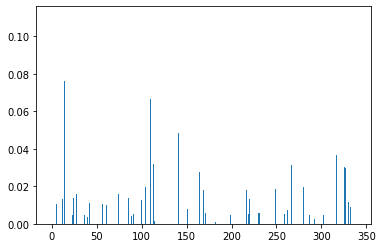

x311 0.11040028999728616
x12 0.07593896301443162
x108 0.06665403182344859
x139 0.04861111111111111
x104 0.044722224333564715
x315 0.036892099258017085
x164 0.03445598544872722
x111 0.031910988798875356
x265 0.031126010137816
x324 0.03020111288845139


In [ ]:
# RF Feature importance
importance = model5_y1.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

for importance, name in sorted(zip(model5_y1.feature_importances_, x.columns), reverse=True)[:10]:
    print (name, importance)

## XGBoost

Random Forest did not improve the performance, let's also try another tree-based algorithm, XGBoost. From readings, XGBoost tend to have better performance than logistic regression. It is a very flexible algorithm with inherent regularization. We will use n_estimator obtained from random forest grid search.

In [ ]:
from xgboost import XGBClassifier
parameters = {
    'max_depth' : [3,4,5],
    'learning_rate' : [0.1, 0.2]
}
Grid = GridSearchCV(XGBClassifier(n_estimators=9, objective='binary:logistic'), parameters, cv=5)
Grid.fit(x_train, y_train['y1'])
print("Best parameters: " + str(Grid.best_params_))
print("Best score: " + str(Grid.best_score_))

model6_y1 = Grid_RF.best_estimator_
model6_y1.fit(x_train, y_train['y1'])
pred = model6_y1.predict(x_test)
print("Accuracy: ", model6_y1.score(x_test, y_test['y1']))
print("Confusion matrix: ")
print(confusion_matrix(y_test['y1'], pred))
model6_y1_score = model6_y1.score(x_test, y_test['y1'])

Best parameters: {'learning_rate': 0.2, 'max_depth': 3}
Best score: 0.7941176470588235
Accuracy:  0.6956521739130435
Confusion matrix: 
[[12  3]
 [ 4  4]]


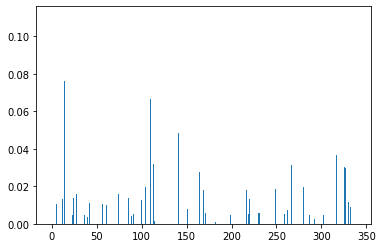

x311 0.11040028999728616
x12 0.07593896301443162
x108 0.06665403182344859
x139 0.04861111111111111
x104 0.044722224333564715
x315 0.036892099258017085
x164 0.03445598544872722
x111 0.031910988798875356
x265 0.031126010137816
x324 0.03020111288845139


In [ ]:
# XGBoost Feature importance
importance = model6_y1.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

for importance, name in sorted(zip(model6_y1.feature_importances_, x.columns), reverse=True)[:10]:
    print (name, importance)

## SVM

SVM can be very powerful fitting nonlinear decision boundaries and works well with high dimensional datasets. We will implement SVM trying different kernel types.

In [ ]:
from sklearn.svm import SVC 
parameters = {
    'kernel' : ['linear', 'poly', 'rbf']
}

# Approach 1 without feature selection
Grid = GridSearchCV(SVC(random_state=0), parameters, cv=5)
Grid.fit(x_train, y_train['y1'])
print("Best parameters: " + str(Grid.best_params_))
print("Best score: " + str(Grid.best_score_))

model71_y1 = Grid.best_estimator_
model71_y1.fit(x_train, y_train['y1'])
pred = model71_y1.predict(x_test)
print("Accuracy: ", model71_y1.score(x_test, y_test['y1']))

Best parameters: {'kernel': 'rbf'}
Best score: 0.7836601307189542
Accuracy:  0.782608695652174


In [ ]:
# Approach 2 with ANOVA selected features
Grid.fit(x_train_anova_y1, y_train['y1'])
print("Best parameters: " + str(Grid.best_params_))
print("Best score: " + str(Grid.best_score_))

model72_y1 = Grid.best_estimator_
model72_y1.fit(x_train_anova_y1, y_train['y1'])
pred = model72_y1.predict(x_test_anova_y1)
print("Accuracy: ", model72_y1.score(x_test_anova_y1, y_test['y1']))
model7_y1_score = model72_y1.score(x_test_anova_y1, y_test['y1'])

Best parameters: {'kernel': 'rbf'}
Best score: 0.8509803921568627
Accuracy:  0.782608695652174


## Summary

Overall, logistic regression seems the most robust under different feature selection approaches. Naive Bayes and KNN are significantly affected based on feature selection technique used. The PCA dimension reduction shows good results with some models (Logistic Regression) and bad with others (Naive Bayes). A single Decision Tree only picked a few important features, whereas random forest and XGBoost selected more features.

Note that we could have compared the models' performance more carefully using multiple metrics, such as precision, recall, F1, etc., and have functions that pick thresholds the maximize certain metrics. However, the determinationg of the "best model" is based on a priorization of the metric which depends on the real application scenario. So model evaluation has not been dived in this exercise.

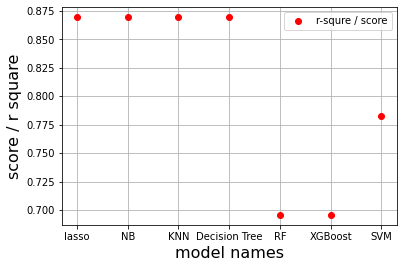

In [ ]:
scores = [model1_y1_score, model2_y1_score, model3_y1_score, model4_y1_score,
          model5_y1_score, model6_y1_score, model7_y1_score]
models = ['lasso', 'NB', 'KNN', 'Decision Tree', 'RF', 'XGBoost', 'SVM']

plt.figure(1)
plt.plot(models, scores, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

# Multiclass Classifcation

Y2 has three values {0, 1, 2} with quite balanced proportions. We repeat the following implementations:
* Model 1 Logistic regression with approaches for multi-class
* Model 2 Naive Bayes 
* Model 3 KNN
* Model 4 Decision Tree
* Model 5 Random Forest
* Model 6 XGBoost
* Model 7 SVM

To evaluate the performance, we used a weighted AUC of each class and the overall accuracy. Note that we omitted parameter tunning in this section for simplicy.

To adapt the original binary classification algorithms to multi-class problem, there are two options:
* One-vs-Rest: a binary classification conducted for each class
* One-vs-One: a binary classification for each pair of classes

Other classification algorithms inherently allow multi-class labels.

In [ ]:
from sklearn import preprocessing
y2_binarized = preprocessing.label_binarize(y['y2'], classes=[0, 1, 2])

In [387]:
# Logistic Regression with LASSO and One vs Rest strategy
from sklearn.multiclass import OneVsRestClassifier

base_lr = LogisticRegression(solver='liblinear', penalty='l1')
model1_y2 = OneVsRestClassifier(base_lr)
pred = model1_y2.fit(x_train, y_train['y2']).predict_proba(x_test)
model1_y2_score = model1_y2.score(x_test, y_test['y2'])
print("Weighted AUC", roc_auc_score(y_test['y2'], pred, multi_class="ovr", average="weighted"))

pred = model1_y2.fit(x_train, y_train['y2']).predict(x_test)
print(classification_report(y_test['y2'], pred))

Weighted AUC 0.6654031958379785
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.47      0.70      0.56        10
           2       0.50      0.38      0.43         8

    accuracy                           0.52        23
   macro avg       0.66      0.49      0.52        23
weighted avg       0.59      0.52      0.52        23



In [388]:
# Naive bayes with ANOVA selected features
model2_y2 = GaussianNB()
pred = model2_y2.fit(x_train_anova_y2, y_train['y2']).predict_proba(x_test_anova_y2)
model2_y2_score = model2_y2.score(x_test_anova_y2, y_test['y2'])
print("Weighted AUC", roc_auc_score(y_test['y2'], pred, multi_class="ovr", average="weighted"))

pred = model2_y2.fit(x_train_anova_y2, y_train['y2']).predict(x_test_anova_y2)
print(classification_report(y_test['y2'], pred))

Weighted AUC 0.5619472315124487
              precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.60      0.30      0.40        10
           2       0.36      0.50      0.42         8

    accuracy                           0.39        23
   macro avg       0.42      0.40      0.38        23
weighted avg       0.45      0.39      0.39        23



In [389]:
# KNN with PCA
model3_y2 = KNeighborsClassifier(n_neighbors=3)
pred = model3_y2.fit(x_train_pca, y_train['y2']).predict(x_test_pca)
model3_y2_score = model3_y2.score(x_test_pca, y_test['y2'])
print("Approach 2 confusion matrix: ")
print(confusion_matrix(y_test['y2'], pred))
print(classification_report(y_test['y2'], pred))

Approach 2 confusion matrix: 
[[1 2 2]
 [3 2 5]
 [3 1 4]]
              precision    recall  f1-score   support

           0       0.14      0.20      0.17         5
           1       0.40      0.20      0.27        10
           2       0.36      0.50      0.42         8

    accuracy                           0.30        23
   macro avg       0.30      0.30      0.28        23
weighted avg       0.33      0.30      0.30        23



In [382]:
# Decision Tree
model4_y2 = DecisionTreeClassifier(max_depth = 3, random_state=0)
pred = model4_y2.fit(x_train_corr_y2, y_train['y2']).predict(x_test_corr_y2)
model4_y2_score = model4_y2.score(x_test_corr_y2, y_test['y2'])
print("Confusion matrix: ")
print(confusion_matrix(y_test['y2'], pred))
print(classification_report(y_test['y2'], pred))

Confusion matrix: 
[[3 2 0]
 [2 4 4]
 [1 4 3]]
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.40      0.40      0.40        10
           2       0.43      0.38      0.40         8

    accuracy                           0.43        23
   macro avg       0.44      0.46      0.45        23
weighted avg       0.43      0.43      0.43        23



In [381]:
# Random Forest
model5_y2 = RandomForestClassifier(random_state=0, n_estimators=9)
pred = model5_y2.fit(x_train, y_train['y2']).predict(x_test)
model5_y2_score = model5_y2.score(x_test, y_test['y2'])
print("Confusion matrix: ")
print(confusion_matrix(y_test['y2'], pred))
print(classification_report(y_test['y2'], pred))

Accuracy:  0.391304347826087
Confusion matrix: 
[[3 1 1]
 [2 5 3]
 [0 7 1]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.38      0.50      0.43        10
           2       0.20      0.12      0.15         8

    accuracy                           0.39        23
   macro avg       0.39      0.41      0.40        23
weighted avg       0.37      0.39      0.37        23



In [380]:
# XGBoost with softmax for multiclass and ANOVA selected features
# Softmax maps the three categories into probabilities [0, 1]
model6_y2 = XGBClassifier(learning_rate = 0.2, max_depth = 3,
                          objective = 'multi:softmax', tree_method='approx')
pred = model6_y2.fit(x_train_anova_y2, y_train['y2']).predict(x_test_anova_y2)
model6_y2_score = model6_y2.score(x_test_anova_y2, y_test['y2'])
print("Confusion matrix: ")
print(confusion_matrix(y_test['y2'], pred))
print(classification_report(y_test['y2'], pred))

Accuracy:  0.5217391304347826
Confusion matrix: 
[[3 1 1]
 [1 7 2]
 [1 5 2]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.54      0.70      0.61        10
           2       0.40      0.25      0.31         8

    accuracy                           0.52        23
   macro avg       0.51      0.52      0.51        23
weighted avg       0.50      0.52      0.50        23



In [390]:
# SVM
model7_y2 = SVC(random_state=0, kernel='poly')
pred = model7_y2.fit(x_train_anova_y2, y_train['y2']).predict(x_test_anova_y2)
model7_y2_score = model7_y2.score(x_test_anova_y2, y_test['y2'])
print("Accuracy: ", model7_y2_score)
print("Confusion matrix: ")
print(confusion_matrix(y_test['y2'], pred))
print(classification_report(y_test['y2'], pred))

Accuracy:  0.4782608695652174
Confusion matrix: 
[[ 1  3  1]
 [ 0 10  0]
 [ 0  8  0]]
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.48      1.00      0.65        10
           2       0.00      0.00      0.00         8

    accuracy                           0.48        23
   macro avg       0.49      0.40      0.33        23
weighted avg       0.42      0.48      0.35        23



## Summary

Overall, none of the models are performing well predicting for y2. The logistics regression achieved the highest accuracy score, followed by XGBoost and SVM. Again, we could have compared other metrics.

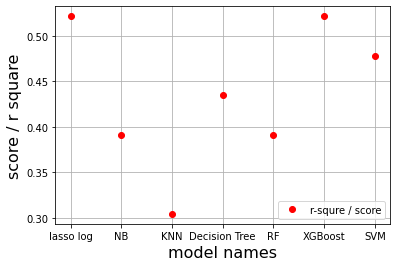

In [517]:
scores = [model1_y2_score, model2_y2_score, model3_y2_score, model4_y2_score,
          model5_y2_score, model6_y2_score, model7_y2_score]
models = ['lasso log', 'NB', 'KNN', 'Decision Tree', 'RF', 'XGBoost', 'SVM']

plt.figure(1)
plt.plot(models, scores, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

# Multi-Label Classification

There are three main approaches to solve multi-label classification ([Madjarov et al](http://kt.ijs.si/DragiKocev/wikipage/lib/exe/fetch.php?media=2012pr_ml_comparison.pdf)):
* Problem transformation
 * Binary Relevance 
 * Classifier Chain
 * Label Powerset 
* Adapting existing algorithms
 * KNN 
 * Decision Tree
 * SVM
* Ensemble approach

We first binarized y2 using one-hot encoding because most built-in classifiers cannot handle a mix of multiclass and multilabel responses. This step creates 2 columns for y2. 

To evaluate the performance of multi-label prediction, we used:
* Accuracy score for y1
* Subset accuracy of the three y2 binary columns such that a correct classification means all three binary values match, and the total accuracy score is the fraction of correctly classified data points
* We also output the classification report which treats the tree binary columns are separate labels to get some extra information

We omitted parameter tunning in this section for simplicity, since the focus of this exercise is algorithm implementation and not model performance optimization. We showed the parameter tuning process in a previous section.





In [360]:
# binarize y2
from sklearn.preprocessing import MultiLabelBinarizer
y_train_binary = MultiLabelBinarizer().fit_transform(np.asarray(y_train))
y_test_binary = MultiLabelBinarizer().fit_transform(np.asarray(y_test))

## Problem Transformation

### Binary Relevance

BR is known as the one-against-all
strategy It learns one classifier for each label, treating each label as a single classification problem. This approach ignores the relationship between labels.

We will base our binary relevance procedure on LASSO logistic regression since from previous sections we know it performs well on our data.

In [506]:
# binary relevance with LASSO logistic regression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score

model1 = BinaryRelevance(LogisticRegression(solver='liblinear', penalty='l1'), require_dense=(True, True))
pred = model1.fit(x_train, y_train_binary).predict(x_test).toarray()
model1_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model1_score[0])
print("Accuracy for y2:", model1_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.782608695652174
Accuracy for y2: 0.4782608695652174
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.79      0.79      0.79        14
           2       0.43      0.38      0.40         8

   micro avg       0.74      0.74      0.74        39
   macro avg       0.68      0.68      0.68        39
weighted avg       0.73      0.74      0.74        39
 samples avg       0.80      0.76      0.74        39



### Classifier Chain 

Tackles the multi-label problem with a sequence of classifiers linked in a chain, where the i-th classifier is trained including the input space with all the features and the previous classifiers. We will use a classifier chain of logistic regression since we know that logistic regression fits well to the data.

Note that using classifier chain on y2 is "cheating", since we binarized y2 into two binary labels, knowing the first label should help predict the second label. So we expect the accuracy for y2 to be higher. Knowing that it is not a fair application of the algorithm, we will still implement it to try how it works.

In [507]:
# classifier chain with LASSO logistic regression
from sklearn.multioutput import ClassifierChain

model2 = ClassifierChain(LogisticRegression(solver='liblinear', penalty='l1'))
pred = model2.fit(x_train, y_train_binary).predict(x_test)
model2_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model2_score[0])
print("Accuracy for y2:", model2_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.782608695652174
Accuracy for y2: 0.5217391304347826
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.79      0.79      0.79        14
           2       0.50      0.25      0.33         8

   micro avg       0.78      0.72      0.75        39
   macro avg       0.71      0.64      0.66        39
weighted avg       0.75      0.72      0.72        39
 samples avg       0.80      0.74      0.74        39



### Label Power-set 

The Label Power-set treats the multi-label problem as a multi-class problem, where each unique combination of the labels is treated as a class. Whether this method is applicable depends on the classification context. We will implement it as follows

In [508]:
# Label Powerset with LASSO log regression
from skmultilearn.problem_transform import LabelPowerset

model3 = LabelPowerset(LogisticRegression(solver='liblinear', penalty='l1'))
pred = model3.fit(x_train, y_train_binary).predict(x_test).toarray()
model3_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model3_score[0])
print("Accuracy for y2:", model3_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.782608695652174
Accuracy for y2: 0.4782608695652174
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.62      0.71      0.67        14
           2       0.40      0.25      0.31         8

   micro avg       0.70      0.67      0.68        39
   macro avg       0.63      0.60      0.61        39
weighted avg       0.69      0.67      0.67        39
 samples avg       0.72      0.70      0.69        39



## Adapted Algorithm

### ML-kNN

ML-kNN assumes independence among the labels and gives an equal weight to each label occurrence in the neighborhood of the input instance. We use k = 6 = 2 x 3 which makes sense in our context.



In [509]:
from skmultilearn.adapt import MLkNN
model4 = MLkNN(k=6) 

# with ANOVA selected features (union)
pred = model4.fit(x_train_anova, y_train_binary).predict(x_test_anova).toarray()
model4_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model4_score[0])
print("Accuracy for y2:", model4_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.8260869565217391
Accuracy for y2: 0.391304347826087
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.62      0.57      0.59        14
           2       0.45      0.62      0.53         8

   micro avg       0.68      0.72      0.70        39
   macro avg       0.65      0.69      0.67        39
weighted avg       0.70      0.72      0.71        39
 samples avg       0.70      0.76      0.70        39



In [499]:
# with PCA 
pred = model4.fit(x_train_pca, y_train_binary).predict(x_test_pca).toarray()
print("Accuracy for y1:", accuracy_score(y_test_binary[:, 0], pred[:, 0]))
print("Accuracy for y2:", accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4]))
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.8260869565217391
Accuracy for y2: 0.34782608695652173
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       0.67      0.43      0.52        14
           2       0.36      0.62      0.45         8

   micro avg       0.64      0.72      0.67        39
   macro avg       0.61      0.68      0.62        39
weighted avg       0.67      0.72      0.67        39
 samples avg       0.63      0.72      0.65        39



### Decision tree

The decision tree implemention also inherently supports multiple labels so we will call the package directly

In [510]:
model5 = DecisionTreeClassifier(random_state=0)
model5.fit(x_train, y_train_binary)
pred = model5.predict(x_test)
model5_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model5_score[0])
print("Accuracy for y2:", model5_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.8260869565217391
Accuracy for y2: 0.4782608695652174
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.77      0.71      0.74        14
           2       0.33      0.25      0.29         8

   micro avg       0.74      0.72      0.73        39
   macro avg       0.65      0.64      0.64        39
weighted avg       0.71      0.72      0.71        39
 samples avg       0.74      0.74      0.72        39



### SVM with OneVsRest

In [511]:
# OneVsRest with SVM as base classifier
model6 = OneVsRestClassifier(SVC(random_state=0, kernel='poly'))
pred = model6.fit(x_train_anova, y_train_binary).predict(x_test_anova)
model6_score = [accuracy_score(y_test_binary[:, 0], pred[:, 0]), accuracy_score(y_test_binary[:, 1:4], pred[:, 1:4])]
print("Accuracy for y1:", model6_score[0])
print("Accuracy for y2:", model6_score[1])
print(classification_report(y_test_binary, pred))

Accuracy for y1: 0.782608695652174
Accuracy for y2: 0.5652173913043478
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.67      1.00      0.80        14
           2       0.00      0.00      0.00         8

   micro avg       0.71      0.77      0.74        39
   macro avg       0.49      0.65      0.55        39
weighted avg       0.59      0.77      0.66        39
 samples avg       0.74      0.80      0.75        39



## Summary

The following plot summarizes the performance of the six multi-label classification models. We chose to report the performance of y1 and y2 separately, considering them as two independent labels. Another way is to report an aggregate  metric for the two labels.

Among these approaches, binary Relevance, ML-kNN, and SVM with OneVsRest assumes that labels are independent and do not use other labels' information to classify the current label. On the other extreme, Label powerset considers the unique combination of the labels as one class.

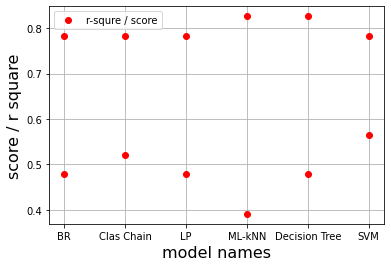

In [516]:
scores = [model1_score, model2_score, model3_score, model4_score, model5_score, model6_score]
models = ['BR', 'Clas Chain', 'LP', 'ML-kNN', 'Decision Tree', 'SVM']

plt.figure(1)
plt.plot(models, scores, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

# Final Discussion

Amongs the various feature selection techniques, the feature selection based on ANOVA F-tests seems to be more effective than the correlation approach. Using these two methods, setting thresholds to select 50-60 features achieved highest classification performance in most of the models. On the other side, PCA was only able to reduce the feature space to up to six dimensions. Using the six dimensional dataset we were also able to achieve good performance (AUC>0.8) in some models. 

Roughly comparing the performance of the models on this dataset, Logistics regression and XGBoost performed the best classifying both y1 and y2. Naive Bayes and KNN seem to be susceptible to feature selection. To do a careful comparison, we would need to select a performance metric and do careful parameter tuning. 

We learned that while some traditional classification models do not support multiclass or multi-label classification, we can adapt these algorithms with supplemental techniques (e.g. OneVsRest or pipelines) so they can be applied to multiclass or multi-label problems. In algorithm packages where multiclass is not supported, we can binarize the target. 

We learned that the advantage of multi-label classification is first, convenience (not need to build separate classifiers); and second, the ability to utilize any interdependence or relationship between the target variables. 

# References

Sorower, Mohammad. (2020). A Literature Survey on Algorithms for Multi-label Learning. 

Zhang, M., & Zhou, Z. (2007). ML-KNN: A lazy learning approach to multi-label learning. Pattern Recognition,
40(7), 2038–2048

Madjarov, G., et al (2012). An extensive experimental comparison of methods for multi-label learning. Pattern Recognition. doi:10.1016/j.patcog.2012.03.004

Scikit-multilearn. 
http://scikit.ml/concepts.html#Single-label-vs-multi-label-classification

## Additional Readings

* Hierarchical multi-label classification https://www.researchgate.net/publication/226246349_Decision_trees_for_hierarchical_multi-label_classification
* Ensemble methods for multi-label classification https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiS5JqMlKbsAhVmh-AKHb_9CScQFjABegQIBBAC&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1307.1769&usg=AOvVaw37qb3nqdW-2syWDbjk8qYp
* Rank SVM: Joachims, T. (2002), "Optimizing Search Engines using Clickthrough Data", Proceedings of the ACM Conference on Knowledge Discovery and Data Mining
* IBLR-ML: multi-label model that explicitly models pairwise dependencies among categories
using logistic regression